In [125]:
dataRDD = sc.textFile('data/nsw_temp.csv')

In [126]:
dataRDD.take(10)

[u'Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality',
 u'IDCJAC0010,061087,1965,01,01,25.6,,Y',
 u'IDCJAC0010,061087,1965,01,02,32.2,1,Y',
 u'IDCJAC0010,061087,1965,01,03,23.1,1,Y',
 u'IDCJAC0010,061087,1965,01,04,25.6,1,Y',
 u'IDCJAC0010,061087,1965,01,05,26.7,1,Y',
 u'IDCJAC0010,061087,1965,01,06,25.3,1,Y',
 u'IDCJAC0010,061087,1965,01,07,20.3,1,Y',
 u'IDCJAC0010,061087,1965,01,08,22.5,1,Y',
 u'IDCJAC0010,061087,1965,01,09,24.2,1,Y']

In [127]:
print(dataRDD.getNumPartitions())
dataRDD = sc.textFile('data/nsw_temp.csv', 4)
print(dataRDD.getNumPartitions())

2
4


In [128]:
print(dataRDD.getStorageLevel())
dataRDD.cache()
print(dataRDD.getStorageLevel())

Serialized 1x Replicated
Memory Serialized 1x Replicated


In [129]:
dataRDD.count()

352737

In [130]:
from collections import namedtuple


BomRecord = namedtuple('BomRecord', 
        ['product_code', 'station_number', 'year', 'month', 'day', 'max_temp', 'days_of_acc', 'quality'])


bomRDD = dataRDD \
    .filter(lambda line: line.startswith('IDCJAC')) \
    .map(lambda line: BomRecord(*line.split(',')))

bomRDD.take(3)

[BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'01', max_temp=u'25.6', days_of_acc=u'', quality=u'Y'),
 BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'02', max_temp=u'32.2', days_of_acc=u'1', quality=u'Y'),
 BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'03', max_temp=u'23.1', days_of_acc=u'1', quality=u'Y')]

In [131]:
import string
from functools import partial


def apply_types(*types):
    return lambda strlist: ( t(v) if v else None for t,v in zip(types, strlist))


bomRDD = dataRDD \
    .filter(lambda line: line.startswith('IDCJAC')) \
    .map(lambda line: BomRecord(*apply_types(str, str, int, int, int, float, str, bool)(line.split(','))))

bomRDD.take(3)

[BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=1, max_temp=25.6, days_of_acc=None, quality=True),
 BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=2, max_temp=32.2, days_of_acc='1', quality=True),
 BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=3, max_temp=23.1, days_of_acc='1', quality=True)]

In [132]:
bomRDD.cache().count()

352696

In [133]:
import operator
print(bomRDD.map(lambda r:r.station_number).distinct().count())
print(bomRDD.map(operator.attrgetter('year')).distinct().count())

print(bomRDD.map(operator.attrgetter('max_temp')).filter(lambda v: v is not None).stats())




41
155
(count: 314092, mean: 22.8129516193, stdev: 5.31792943713, max: 46.5, min: 0.0)


In [134]:
observationsPerYear = bomRDD.map(lambda r: (r.year, 1)) \
    .reduceByKey(operator.add) \
    .sortByKey() \
    .collect()
    
print(observationsPerYear[0:3])

[(1859, 365), (1860, 366), (1861, 365)]


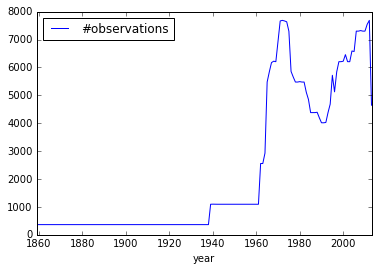

In [135]:
import pandas as pd
from matplotlib import pyplot as plt

observationsPerYearPD = pd.DataFrame.from_records(observationsPerYear, columns=['year', '#observations'], index='year')
observationsPerYearPD.plot(kind='line')
plt.show()
display()

In [136]:
top_station_id, top_number = bomRDD \
    .filter(lambda r: r.max_temp is not None) \
    .map(lambda r: (r.station_number, 1)) \
    .reduceByKey(operator.add) \
    .sortBy(lambda t:t[1], False) \
    .first()
    
print("Station: %s has most observations: %s" % (top_station_id, top_number))

Station: 066062 has most observations: 56317


In [137]:
seqOp = (lambda sumAndCount, v: (sumAndCount[0] + v, sumAndCount[1] + 1))
combOp = (lambda sumAndCount1, sumAndCount2: (sumAndCount1[0] + sumAndCount2[0], sumAndCount1[1] + sumAndCount2[1]))

averageYearlyTemps = bomRDD \
    .filter(lambda r: r.station_number == top_station_id) \
    .filter(lambda r: r.max_temp is not None) \
    .map(lambda r: (r.year, r.max_temp)) \
    .aggregateByKey((0.0, 0), seqOp, combOp) \
    .map(lambda (year,sumAndCount): (year, sumAndCount[0]/ sumAndCount[1])) \
    .sortByKey() \
    .collect()
    
print(averageYearlyTemps[0:3])

[(1859, 21.399452054794523), (1860, 20.276986301369863), (1861, 20.864657534246582)]


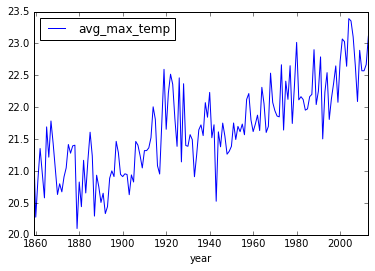

In [138]:
import pandas as pd
from matplotlib import pyplot as plt

averageYearlyTempsPD = pd.DataFrame.from_records(averageYearlyTemps, columns=['year', 'avg_max_temp'], index='year')
averageYearlyTempsPD.plot()
plt.show()
display()